*Amanda Maiwald - maiwald@posteo.de - Mat.-No.599665*

------

# ADAMS NLP SS2019
--------


## Introduction

In the past few years, data science has become an increasingly popular area of research. When studying data science it is almost impossible not to read articles published on Medium on a regular basis, as the website stores an extremely large amount of articles about this topic. Medium works with "claps" to enable readers to show their appreciation of an article. Machine learning algorithms can be applied to predict the claps an article received, given the text and meta information.

The following report describes the procedure of solving this natural language processing task with a neural network. Two different data sets are available to build and train the model. An unlabelled smaller data set is then used to make predictions. These predictions are uploaded to a Kaggle challenge and benchmarked against the predictions of other students. The report on the methodology and results is divided into the following sections:
1. Exploratory Data Analysis
2. Data Preparation
3. Model Tuning and Selection
4. Model Evaluation
5. Discussion and outlook

---

## 1. Exploratory Data Analysis

There are three data sets that are available for the following task. Two data sets containing articles, meta information and claps and a third data set without claps, which the prediction will be made on. The two training data sets differe significantly in their lenght and width. Furthermore the test data set contains a different number of columns than both of them.  

In the end only the features present in the test data set can be used for predictions. Therefore any additional columns in the training data sets can be discarded. The columns from test are all present in the aggr data set. Therefore the aggr data set is reduced to these features.  

However the articles data set contains fewer columns than the test data set. These values could be imputed on the basis of the aggr data sets values for the missing columns. However the articles data set only contains 287 unique rows that are not already present in the aggr data. As this represent less than 1% of the data already present in aggr it will not impact the the model in any relevant way. The articles data set will therefore not be used.

| Data Set                  | Variable Name | # Original Rows |  # Unique Rows | # Columns | Contains Claps |
| ------------------------- | --------------| --------------- | -------------- | --------- | -------------- |
| Medium_AggregatedData.csv | aggr          |279,577         | 72,285         | 50        | Yes            |
| Articles.csv              | articles      |337             | 287            | 6         | Yes            |
| test.csv                  | test          |514             | 514            | 8         | No             |

The following independant variables are present in the test data set and the aggr data set and will be explored in more detail:
```Author```  ```PublicationDetails```  ```Responses```  ```Header```  ```Text```  ```Length```  
Before diving into the data analysis some preliminary thoughts and hypotheses on the topic should be noted: Medium articles can only receive 'positive' claps. This means that the more people read an article, the more likely it is to have a high clap rating. Important factors on the amount claps will therefore be characteristics that lead to a large reader group. It could be possible that certain author have a loyal fan base. Moreover popular topics will attract large numbers of readers. It is also conceivable that the length of the article or the header influence the number of peaople reading an article. In general articles that are older will have more claps than articles that were posted very recently, as they have had more time to collect claps. The weekday that an article was published on might also impact the amount of claps as it it conceivable that people primarily read on certain weekdays for example the weekend. It might also be of interest to look at the different websites that articles were published on, as larger websites have a larger group of possible readers that can be reached. These hypotheses will be insepcted and tested during the following data analysis.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
import re
import collections
import h5py

import keras as keras
from keras import backend as K
from keras.utils import np_utils, multi_gpu_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.layers import Dropout, Activation, Flatten, Dense, Embedding, LSTM, GRU, Input, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.applications import Xception
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import gensim
from gensim.models import Word2Vec 

import time
from datetime import datetime as dt

import pickle

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from scipy import sparse

In [6]:
# Load data
articles = pd.read_csv('articles.csv')
aggr = pd.read_csv('Medium_AggregatedData.csv')
test = pd.read_csv('test.csv')

In [7]:
ran = 42

### Independent Variable: Author

The variable ```Author``` names the author of the respective article. The articles in the training data set aggr are written by 31,021 different authors. The author with the highest number of published articles is 'Synced' with 378 published articles. The articles in the test data set are written by 225 different authors. The most active author in this data set is the 'Netflix Technology Blog' with 175 published articles. The scatterplot below shows the relation between the number of articles an author published and the amount of claps that the respective article got. It appears that articles by very active authors do often receive very little claps. On the other hand may authors only published a handful of articles and received a large number of claps. Figure 2 shows the claps that authors who published between 1 and 11 articles received on average on their articles. As 50% of all authors published 11 articles or less, this shows an interesting part of the data. Here it can be observed that authors who published more articles receved on average more claps.

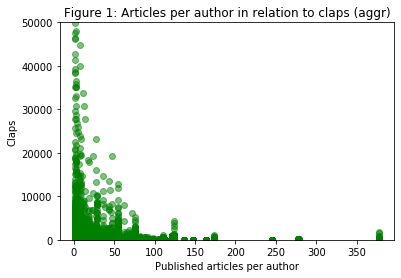

In [92]:
import matplotlib.pylab as plb
x = aggr_clean2['Author_count']
y = aggr_clean2['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Published articles per author")
plt.ylabel("Claps")
plt.title('Figure 1: Articles per author in relation to claps (aggr)')
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,50000])
plt.show()

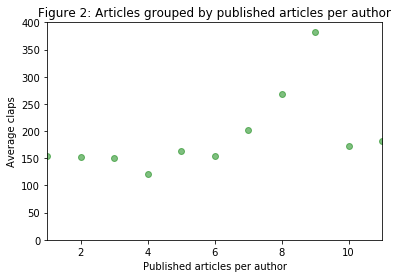

In [95]:
author_count_mean_claps = aggr_clean2.groupby(['Author_count']).mean()
x = author_count_mean_claps.index
y = author_count_mean_claps['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Published articles per author")
plt.ylabel("Average claps")
plt.title('Figure 2: Articles grouped by published articles per author')
axes = plt.gca()
axes.set_xlim([1,11])
axes.set_ylim([0,400])
plt.show()

### Independent Variable: PublicationDetails

The variable PublicationDetails from the test data set is an aggregate of the publish date, the authors name and the website the article was published on. The publication date will be extracted from it as it can be found in the training data as well. The publishing date of the training and the test data set stretch from 2010-12-01 untill the 2018-12-28. Figure 3 shows that the older the article is, the more claps is received. This is in accordance with the hypotheses that was stated in the introduction.  

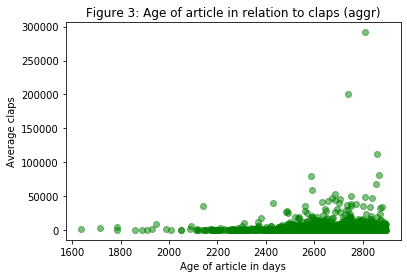

In [105]:
x = aggr_clean2['Day_nr']
y = aggr_clean2['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Age of article in days")
plt.ylabel("Average claps")
plt.title('Figure 3: Age of article in relation to claps (aggr)')
axes = plt.gca()
#axes.set_xlim([1,11])
#axes.set_ylim([0,400])
plt.show()

Another hypotheses that was stated in the introduction is that the weekday that an article was published, influences the amount of claps it receives. This is based on the assumption that it matters how many claps an article receives right after it was published. This might be the case if Medium works with an algorithm that promotes articles that have a high engagement rate right after beeing published (similiar to some social media websites). Figure 4 does show that articles first published on a sunday do indeed receive on average more claps than articles piblished on other days.

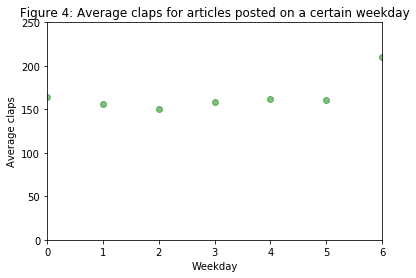

In [109]:
weekday_mean_claps = aggr_clean2.groupby(['Weekday']).mean()
x = weekday_mean_claps.index
y = weekday_mean_claps['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Weekday")
plt.ylabel("Average claps")
plt.title('Figure 4: Average claps for articles posted on a certain weekday')
axes = plt.gca()
axes.set_xlim([0,6])
axes.set_ylim([0,250])
plt.show()

### Independent Variable: Responses

The variable 'Responses' counts the number of comments an article received. Most of the articles did not receive any claps, as the avery number of responses per articles is 0.85. Figure 5 shows an excerpt of the responses until 200 as less than 1% of the articles received more than 200 responses. In this excerpt it can be observed that the number of responses correlates positively with the number of claps an article got.

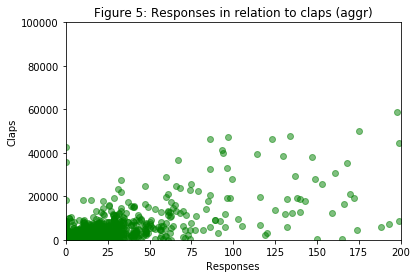

In [114]:
x = aggr_clean2['Responses']
y = aggr_clean2['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Responses")
plt.ylabel("Claps")
plt.title('Figure 5: Responses in relation to claps (aggr)')
axes = plt.gca()
axes.set_xlim([0,200])
axes.set_ylim([0,100000])
plt.show()

### Independent Variables Header

The variable ```Header``` is a textual variable containing the title of the respective article. It is one of two variables that will be used during the process of natural language processing. Before dinving into NLP another feature will be created from it: ```Header length```, which is the number of words the header has. Figure 6 shows that articles with very short or very long titles seem to receive fewer claps. Intuitively this seems to make sense as a very short title is uninformative and a very long on might not be very appealing.

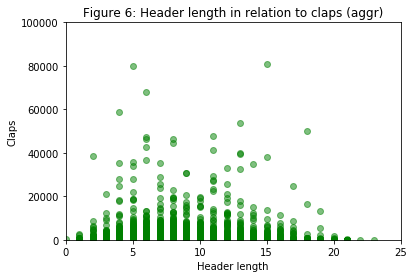

In [158]:
x = aggr_clean2['Header_length']
y = aggr_clean2['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Header length")
plt.ylabel("Claps")
plt.title('Figure 6: Header length in relation to claps (aggr)')
axes = plt.gca()
axes.set_xlim([0,25])
axes.set_ylim([0,100000])
plt.show()

### Independent Variables: Text and Text Length

The feature ```Text``` contains the article itself. It will be anaylsed using NLP techniques. The variable ```Text length``` contains the number of words the article has. Figure seven shows that articles that received a lot of claps were seldom longer than 5000 words long.

In [165]:
np.percentile(aggr_clean2['Text_length'], 75)

1119.0

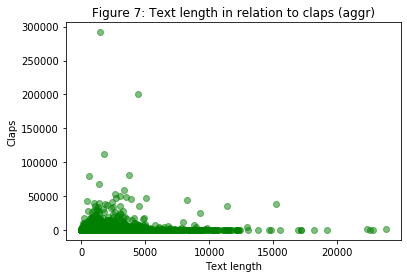

In [172]:
x = aggr_clean2['Text_length']
y = aggr_clean2['Claps']
plt.scatter(x, y, c="g", alpha=0.5)
plt.xlabel("Text length")
plt.ylabel("Claps")
plt.title('Figure 7: Text length in relation to claps (aggr)')
axes = plt.gca()
#axes.set_xlim([0,np.percentile(aggr_clean2['Text_length'], 75)])
#axes.set_ylim([0,25000])
plt.show()

### Dependant Variable: Count of claps for articles

The table below shows the distribution of the dependent variable claps per article. The highest number of claps an article got in our training data is 291,706 claps and the lowest 0 claps. However 75% of the articles in the training data set have 72 or less claps. 50% of all articles have 8 claps or less. And 25% of the articles did not receive any claps.

In [147]:
print(aggr['totalClapCount'].describe())

count    279577.000000
mean        184.963473
std        1985.353004
min           0.000000
25%           0.000000
50%           8.000000
75%          72.000000
max      291706.000000
Name: totalClapCount, dtype: float64


### Correlation Matrix

Figure 8 shows a correlation matrix of all numeric features. It shows a relatively high positive correlation between the number of responses anf the number of claps. Furthermore a small positive correlation between text length and claps can be observed. It can also be deduced that there is a small correlation between responses and text length, header length and text length and author cound and header length.

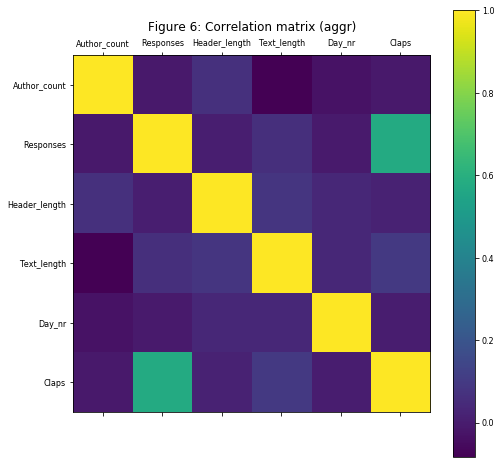

In [156]:
aggr_clean_int = copy.copy(aggr_clean2)
aggr_clean_int = aggr_clean_int[['Author_count', 'Responses', 'Header_length', 'Text_length', 'Day_nr', 'Claps']]

# Plot correlation of numeric variables
f = plt.figure(figsize=(8, 8))
plt.matshow(aggr_clean_int.corr(), fignum=f.number)
plt.title('Figure 8: Correlation matrix (aggr)')
plt.xticks(range(aggr_clean_int.shape[1]), aggr_clean_int.columns, fontsize=8)
plt.yticks(range(aggr_clean_int.shape[1]), aggr_clean_int.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
#plt.title('Correlation Matrix', fontsize=8)

## Data cleaning

There are three data sets that are being used for the task. Two training data sets and the test data set that the prediction will be made on. The smaller training data set contains 337 oberservations and features the variables author, claps, readingtime, link, title and text. The other training data set is much larger with 279,577 observations and 50 variables.
The test data set contains 514 rows and 8 variables.
For training purposes the larger data set will be used as the small one does not contain enough data.

### Cleaning test data

In [17]:
test_clean = copy.copy(test) # safety copy

# remove unecessary columns
test_clean = test_clean.drop(['Unnamed: 0','index'], axis = 1)
test_cols = list(test_clean.columns.values)

# Split publication details before date
new = test_clean['PublicationDetails'].str[-13:].str.split('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', n = 1, expand = True)
new = new.drop([0], axis = 1)
new2 = new[2].str.split(', ', expand = True)
d = {'month': new[1], 'day': new2[0], 'year' : new2[1]}
published = pd.DataFrame(d)
print("Frequency of the elements in the List : ",collections.Counter(published['year'])) # Most frequent year: 2018
# Set missing year to most frequent year
published = published.replace([None], '2018') 
published['date'] = published['day']+'-'+published['month']+'-'+published['year']
published['date'] = pd.to_datetime(published['date'])
published['date_num'] = pd.to_datetime(published['date'], format = '%Y%m%d')
published['Weekday'] = published['date'].dt.dayofweek
#print(min(aggr['latestPublishedDate'])) #find earliest date to count days from there on
#print(min(published['date_num']))
start_date = min(published['date_num'])
published['start_date'] = start_date

# Get number of days since earliest date
published['Day_nr'] = published['date_num']-published['start_date']
published['Day_nr'] = published['Day_nr']/np.timedelta64(1, 'D')
published['Day_nr'] = published['Day_nr'].astype(int)

# Create variable for published on which weekday
test_clean['Weekday'] = published['Weekday']
test_clean['Day_nr'] = published['Day_nr']

# Clean up variable for responses
test_clean2 = copy.copy(test_clean)
new4 = test_clean2['Responses'].str.split('(responses|response)', n = 1, expand = True) # rem
test_clean2['Responses'] = new4[0]
print("Frequency of the elements : ",collections.Counter(test_clean2['Responses'])) #Problem with NaN and commas
# remove commas in 1,000
test_clean2['Responses'] = test_clean2['Responses'].str.replace(',','')
# Replace NaN values with 0 and convert to int
test_clean2['Responses'] = test_clean2['Responses'].fillna(0).astype(int)

# Clean header variable
test_clean2['Header'] = test_clean2['Header'].fillna('').astype(str) # replace nan with 0 and convert to string
test_clean2['Header'] = test_clean2['Header'].astype(str)

# Create variable for header length
test_clean2['Header_length'] = test_clean2['Header'].apply(lambda x: len(x.split()))

# Combine header and text body
test_clean2['Text_complete'] = test_clean2['Header'] + test_clean2['Text']

# Drop unnecessary columns
test_clean2 = test_clean2.drop(['PublicationDetails'], axis = 1)

# Count published articles per author
test_author_count = test_clean2['Author'].value_counts().reset_index(name='Author_count').rename(columns={'index': 'Author'})
test_author_count
test_clean2 = pd.merge(test_clean2,test_author_count,on=['Author'], how='left' )

# Rename and reorder columns
test_clean2.columns = ['Author', 'Responses', 'Header', 'Text', 'Text_length', 'Weekday','Day_nr',
                       'Header_length', 'Text_complete', 'Author_count']
test_clean2 = test_clean2[['Author_count', 'Responses', 'Header', 'Text', 'Text_complete', 'Header_length',
                           'Text_length', 'Day_nr', 'Weekday']]

Frequency of the elements in the List :  Counter({'2018': 196, '2017': 122, '2016': 72, None: 71, '2015': 30, '2012': 8, '2011': 6, '2014': 4, '2013': 3, '2010': 2})
Frequency of the elements :  Counter({nan: 82, '1 ': 62, '4 ': 45, '3 ': 44, '2 ': 44, '7 ': 28, '5 ': 22, '8 ': 17, '13 ': 13, '10 ': 12, '6 ': 12, '9 ': 9, '15 ': 8, '18 ': 6, '14 ': 6, '17 ': 6, '11 ': 5, '20 ': 4, '76 ': 4, '23 ': 3, '31 ': 3, '116 ': 3, '26 ': 3, '53 ': 3, '49 ': 2, '36 ': 2, '22 ': 2, '33 ': 2, '12 ': 2, '1,263 ': 2, '190 ': 2, '16 ': 2, '55 ': 2, '61 ': 2, '42 ': 2, '21 ': 2, '34 ': 2, '24 ': 2, '627 ': 1, '156 ': 1, '176 ': 1, '72 ': 1, '19 ': 1, '67 ': 1, '355 ': 1, '323 ': 1, '113 ': 1, '108 ': 1, '77 ': 1, '48 ': 1, '70 ': 1, '25 ': 1, '59 ': 1, '27 ': 1, '827 ': 1, '175 ': 1, '65 ': 1, '107 ': 1, '35 ': 1, '183 ': 1, '41 ': 1, '1,056 ': 1, '221 ': 1, '161 ': 1, '92 ': 1, '157 ': 1, '146 ': 1, '44 ': 1, '426 ': 1, '163 ': 1, '60 ': 1, '191 ': 1, '51 ': 1, '96 ': 1, '123 ': 1, '39 ': 1, '30 ': 1,

### Design the training data the same ways as the test data e.g. same features, types etc.

In [18]:
aggr_clean = copy.copy(aggr)
aggr_cols_drop = list(aggr_clean.columns.values)

for col in ('author','responsesCreatedCount', 'title', 'text', 'latestPublishedDate', 'totalClapCount'):
    aggr_cols_drop.remove(col)

# Remove columns that are not in test data
aggr_clean = aggr_clean.drop(aggr_cols_drop, axis = 1)

# Remove duplicates
aggr_clean.drop_duplicates(keep='first',inplace=True)

# Rename and reorder columns like test data
aggr_clean.columns = ['date', 'Responses', 'Text', 'Header', 'Claps', 'Author']

aggr_clean2 = copy.copy(aggr_clean) # Safety copy

aggr_clean2['date'] = pd.to_datetime(aggr_clean2['date'])
aggr_clean2['Weekday'] = aggr_clean2['date'].dt.dayofweek
aggr_clean2['start_date'] = start_date
aggr_clean2['Day_nr'] = aggr_clean2['date']-aggr_clean2['start_date'] 
aggr_clean2['Day_nr'] = aggr_clean2['Day_nr']/np.timedelta64(1, 'D')
aggr_clean2['Day_nr'] = aggr_clean2['Day_nr'].astype(int)

aggr_clean2['Header'] = aggr_clean2['Header'].fillna('').astype(str) # replace nan with 0 and convert to string
aggr_clean2['Header'] = aggr_clean2['Header'].astype(str)
aggr_clean2['Header_length'] = aggr_clean2['Header'].apply(lambda x: len(x.split())) # count words of header

aggr_clean2['Text_length'] = aggr_clean2['Text'].apply(lambda x: len(x.split())) # count words of text body

aggr_clean2['Text_complete'] = aggr_clean2['Header'] + aggr_clean2['Text'] # combine header and text body

aggr_clean2 = aggr_clean2.drop(['date', 'start_date', ], axis = 1) # remove columns that are not in test data

# Replace author names with count of their articles
aggr_author_count = aggr_clean2['Author'].value_counts().reset_index(name='Author_count').rename(columns={'index': 'Author'})
aggr_clean2 = pd.merge(aggr_clean2,aggr_author_count,on=['Author'], how='left' )
aggr_clean2 = aggr_clean2[['Author_count', 'Responses', 'Header', 'Text', 'Text_complete', 'Header_length',
                           'Text_length', 'Day_nr', 'Weekday', 'Claps']]

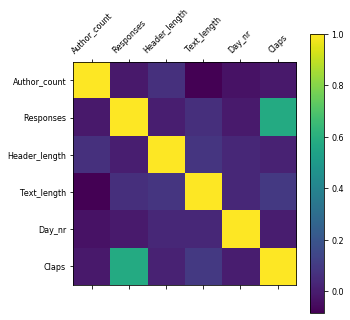

In [8]:
aggr_clean_int = copy.copy(aggr_clean2)
aggr_clean_int = aggr_clean_int[['Author_count', 'Responses', 'Header_length', 'Text_length', 'Day_nr', 'Claps']]

# Plot correlation of numeric variables
f = plt.figure(figsize=(5, 5))
plt.matshow(aggr_clean_int.corr(), fignum=f.number)
plt.xticks(range(aggr_clean_int.shape[1]), aggr_clean_int.columns, fontsize=8, rotation=45)
plt.yticks(range(aggr_clean_int.shape[1]), aggr_clean_int.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
#plt.title('Correlation Matrix', fontsize=8)

-------------

## Inspect articles data set

Besides the large data set there also exists a much smaller data set called articles.csv. At first glimpse it looks like it contains 337 additional rows. however after closer inspection it becomes obvious, that there are 50 articles that exist in the large and the small data set, only differing slightly in their clap counts. The articles data set therefore only contains 287 additional articles. The small data set lacks other important features that are present in the larger data set like publishing date. As the number of articles is very long and will not have an impact of the results made on models on the large data set these articles will not be used in this analysis.

In [102]:
# Check big and small data sets for duplicates
duplicates_df = pd.merge(articles[['author','title', 'claps']], aggr_clean[['Author','Header','Claps']],
                         left_on=('author','title'), right_on=('Author','Header'), how='inner')
duplicates_df = duplicates_df[['author', 'title', 'claps']]

# Remove duplicates
duplicates_df_clean = duplicates_df.drop_duplicates(keep='first',inplace=False) 

# Compare lengths without duplicates
#len(articles.index)- len(duplicates_df_clean.index)

287

-----------

# Preparation for models

In [110]:
train = copy.copy(aggr_clean2)
pred_data = copy.copy(test_clean2)

In [111]:
pred_data.shape
train.shape

(72285, 10)

In [112]:
#train = train.sample(frac=0.02, random_state=ran) # Use small sample for coding to speed up
#train.shape

In [113]:
y = train.pop('Claps')
X = train

### Prepare non textual training data

In [259]:
# Safety copy
meta_data = copy.copy(aggr_clean2)

# Get one hot encoding of columns weekday
one_hot = pd.get_dummies(meta_data['Weekday'])

# Drop column B as it is now encoded
meta_data = meta_data.drop('Weekday',axis = 1)

# Join the encoded df
meta_data = meta_data.join(one_hot)

# Remove text features
meta_data = meta_data.drop(['Header', 'Text', 'Text_complete'],axis = 1)

# Remove predictor variable
meta_data = meta_data.drop(['Claps'], axis = 1)

# Save as matrix for benchmark model
meta_data_matrix = meta_data.values

# Split into training and test data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(meta_data, y, test_size=0.25, random_state=ran)


In [276]:
# Use small sample for coding, remove later
X_train_meta = X_train_meta[0:7500]
y_train_meta = y_train_meta[0:7500]

X_test_meta = X_test_meta[0:2500]
y_test_meta = y_test_meta[0:2500]

### Prepare non textual test data for prediction

In [116]:
# Safety copy
pred_meta_data = copy.copy(pred_data)

# Get one hot encoding of columns weekday 
one_hot_pred = pd.get_dummies(pred_meta_data['Weekday'])
pred_meta_data = pred_meta_data.join(one_hot_pred)

# Remove text features
pred_meta_data = pred_meta_data.drop(['Header', 'Text', 'Text_complete', 'Weekday'],axis = 1)

# Save as matrix for benchmark model
pred_meta_data_matrix = pred_meta_data.values

# Model Building: Neural Network

## Word processing

### Text cleaning

In [117]:
# Lemmatize with POS Tag
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [118]:
def clean_sentences(df):
    reviews = []

    for sent in df:
        review_text = re.sub("[^a-zA-Z]"," ", sent)
    
        # Tokenize the sentences
        words = word_tokenize(review_text.lower())
  
        # Lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [ ]:
### Saved externally, just load it
#start = time.time()
#X_text_clean = clean_sentences(train['Text_complete'])
#end = time.time()
#print('Time for tokenization with 100% of data:', (end-start)/60)

In [121]:
#with open('X_text_clean.pkl','wb') as path_name:
    #pickle.dump(X_text_clean, path_name)
    
with open('X_text_clean.pkl','rb') as path_name:
    X_text_clean = pickle.load(path_name)
    #print(X_text_clean[10000])

In [ ]:
#start = time.time()
#pred_data_text_clean = clean_sentences(pred_data['Text_complete'])
#end = time.time()
#print('Time for tokenization of unknown data in min.:', round((end-start)/60,2))

In [122]:
#with open('pred_data_text_clean.pkl','wb') as path_name:
    #pickle.dump(pred_data_text_clean, path_name)

with open('pred_data_text_clean.pkl','rb') as path_name:
    pred_data_text_clean = pickle.load(path_name)
    #print(pred_data_text_clean[1000])

### Word2vec

In [123]:
emb=100 # size of embedding dimension. 100 because thats what google does

In [ ]:
# Train a Word2Vec model
#start = time.time()
#word2vec = Word2Vec(X_text_clean, 
                 min_count=2, # min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 window=5, #the size of context
                 iter =100, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size=emb, #size of embedding
                 workers=3)#for parallel computing
#end = time.time()
#print('Time for word2vec for 100% of data in min.:', round((end-start)/60,2))
# summarize the loaded model
#print(word2vec)
#words=list(word2vec.wv.vocab)

#with open('word2vec.pkl','wb') as path_name:
    #pickle.dump(word2vec, path_name)

#with open('word2vec.pkl','rb') as path_name:
    #word2vec = pickle.load(path_name)
    #print(word2vec[10])

In [125]:
embs="text_embeddings.txt"
#word2vec.wv.save_word2vec_format(embs, binary=False) #has already been saved

embeddings_index={}
with open("text_embeddings.txt") as loaded_embs:
    for line in loaded_embs:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:])
        embeddings_index[word]=coefs

Transform training text to numbers

In [ ]:
##### Saved externally, just load it
#start = time.time()
#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(X_text_clean)
#seq = tokenizer_obj.texts_to_sequences(X_text_clean) 
#end = time.time()
#print('Time for transforming words to number for 100% of data in min.:', round((end-start)/60,2))

In [126]:
#with open('tokenizer_obj.pkl','wb') as path_name:
    #pickle.dump(tokenizer_obj, path_name)

with open('tokenizer_obj.pkl','rb') as path_name:
    tokenizer_obj = pickle.load(path_name)

In [127]:
#with open('seq.pkl','wb') as path_name:
    #pickle.dump(seq, path_name)

with open('seq.pkl','rb') as path_name:
    seq = pickle.load(path_name)
    #print(seq[1000])

Transform unknown text data to numbers

In [ ]:
##### Saved externally, just load it
#start = time.time() 
#tokenizer_obj_pred = Tokenizer()
#tokenizer_obj_pred.fit_on_texts(pred_data_text_clean)
#seq_pred = tokenizer_obj_pred.texts_to_sequences(pred_data_text_clean)
#end = time.time()
#print('Time for transforming words to number for 100% of unknown data in min.:', round((end-start)/60,2))

In [128]:
#with open('seq_pred.pkl','wb') as path_name:
    #pickle.dump(seq_pred, path_name)

with open('seq_pred.pkl','rb') as path_name:
    seq_pred = pickle.load(path_name)
    #print(seq_pred[10])

### Create embedding matrix

In [129]:
word_index=tokenizer_obj.word_index
len(word_index) # size of vocab/number of unique tokens: 389,226

389226

In [130]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words, emb))
start = time.time()
for word, i in word_index.items():
    if i > num_words:
        continue
    try:
        embedding_vector=embeddings_index[word]
    except KeyError:
        "Do nothing"
    else:
    #dealing with words that we have not embeddings for
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
#embedding_matrix is our lookup table
end = time.time()
print('Time for creating embedding matrix for 100% of data in min.:', round((end-start)/60,2))
print(embedding_matrix.shape) # 
print(num_words) # 

Time for creating embedding matrix for 100% of data in min.: 0.16
(389227, 100)
389227


Find out on which length the sequences should be cut of. 

In [131]:
major_sen = np.percentile([len(s.split()) for s in train['Text_complete']], 50) # cut of text at the length of 50% of the articles
major_sen = int(major_sen)
major_sen = 300 # Assumption, that first 300 words are enough
print(major_sen) 

300


Cut of sequences at determined length.

In [132]:
#padded = pad_sequences(seq, major_sen)
padded = pad_sequences(seq, major_sen)
print(padded.shape) 

(72285, 300)


In [133]:
#padded_pred = pad_sequences(seq_pred, major_sen)
padded_pred = pad_sequences(seq_pred, major_sen)
print(padded_pred.shape) # 212,849 reviews with length 557

(514, 300)


In [260]:
X_train_nn1, X_test_nn1, y_train_nn1, y_test_nn1 = train_test_split(padded, y, test_size=0.25, random_state=ran)

In [275]:
X_train_nn1 = X_train_nn1[0:7500]
y_train_nn1 = y_train_nn1[0:7500]

X_test_nn1 = X_test_nn1[0:2500]
y_test_nn1 = y_test_nn1[0:2500]

---------

# Set up network

# Build multi input model with functional API

### Benchmark

In [218]:
epochs = 25

In [219]:
# Input for NLP branch of model
text_input = Input(shape=(major_sen,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(input_dim = num_words, output_dim = 512, embeddings_initializer=Constant(embedding_matrix),input_length=major_sen,trainable=False)(text_input)

# LSTM layer
text_out = LSTM(32)(x)

# Extra output from text branch
auxiliary_output = Dense(1, activation='relu', name='aux_output')(text_out)

# Extra input from non textual data (meta data)
auxiliary_input = Input(shape=(12,), name='aux_input')

# Concatenate branches
x = keras.layers.concatenate([text_out, auxiliary_input])

# One layer with relu function
x = Dense(16, activation='relu')(x)

# Main layer with relu activation function
main_output = Dense(1, activation='relu', name='main_output')(x)

model_bench = Model(inputs=[text_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Compile model
model_bench.compile(optimizer='adam',
              loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'})

# Define early stopping with callbacks
es = EarlyStopping(monitor='val_main_output_loss', mode='min', min_delta=1, patience=20,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_bench_model.h5', monitor='val_main_output_loss', mode='min', verbose=1)

In [220]:
# Train model
start = time.time()
history_model_bench = model_bench.fit({'text_input': X_train_nn1, 'aux_input': X_train_meta},
          {'main_output': y_train_nn1, 'aux_output': y_train_meta},
          epochs=epochs, batch_size = 256, validation_data = ([X_test_nn1, X_test_meta], [y_test_nn1, y_test_meta]), verbose = 1, callbacks = [es, mc])
end = time.time()
print('Time for training multi input benchmark model on part of data:', round((end-start)/60,2))

Train on 7500 samples, validate on 2500 samples
Epoch 1/25
7500/7500 [==============================] - 84s 11ms/step - loss: 1618915.2125 - main_output_loss: 797969.4108 - aux_output_loss: 820945.8249 - val_loss: 6147100.7608 - val_main_output_loss: 3044963.9024 - val_aux_output_loss: 3102136.8796

Epoch 00001: saving model to best_bench_model.h5
Epoch 2/25
7500/7500 [==============================] - 32s 4ms/step - loss: 1610923.2419 - main_output_loss: 790360.9579 - aux_output_loss: 820562.2864 - val_loss: 6136336.9308 - val_main_output_loss: 3034588.7256 - val_aux_output_loss: 3101748.0148

Epoch 00002: saving model to best_bench_model.h5
Epoch 3/25
7500/7500 [==============================] - 31s 4ms/step - loss: 1608526.3387 - main_output_loss: 788378.7147 - aux_output_loss: 820147.6184 - val_loss: 6134723.2804 - val_main_output_loss: 3033488.4064 - val_aux_output_loss: 3101234.8916

Epoch 00003: saving model to best_bench_model.h5
Epoch 4/25
7500/7500 [==========================

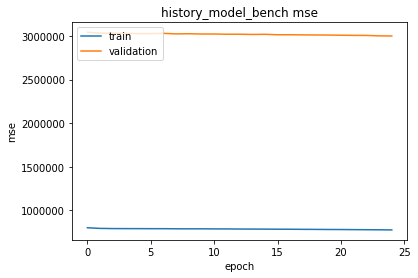

In [221]:
plt.plot(history_model_bench.history['main_output_loss'])
plt.plot(history_model_bench.history['val_main_output_loss'])
plt.title('history_model_bench mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [227]:
min(history_model_bench.history['val_main_output_loss'])

3001913.9204

| Data | Validation MSE |
| -----| -------------- |
|7500  |3,001,913         |  

---

## Build multi input model

In [194]:
epochs = 80

In [195]:
# Input for NLP branch of model
text_input = Input(shape=(major_sen,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(input_dim = num_words, output_dim = 512, embeddings_initializer=Constant(embedding_matrix),input_length=major_sen,trainable=False)(text_input)

# GRU layer
text_out = GRU(64)(x)

# Extra output from text branch
auxiliary_output = Dense(1, activation='relu', name='aux_output')(text_out)

# Extra input from non textual data (meta data)
auxiliary_input = Input(shape=(12,), name='aux_input')


# Concatenate branches
x = keras.layers.concatenate([text_out, auxiliary_input])

# One layer with relu function
x = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(x) 
#x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

# Main layer with relu activation function
main_output = Dense(1, activation='relu', name='main_output')(x)

model_multi = Model(inputs=[text_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Compile model
model_multi.compile(optimizer='adam',
              loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'}
              #,loss_weights={'main_output': 1., 'aux_output': 0.2}
             )

# Define early stopping with callbacks
es = EarlyStopping(monitor='val_main_output_loss', mode='min', min_delta=1, patience=50,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_model_1.h5', monitor='val_main_output_loss', mode='min', verbose=1)

In [196]:
# Train model
start = time.time()
history_model_multi = model_multi.fit({'text_input': X_train_nn1, 'aux_input': X_train_meta},
          {'main_output': y_train_nn1, 'aux_output': y_train_meta},
          epochs=epochs, batch_size=256, validation_data = ([X_test_nn1, X_test_meta], [y_test_nn1, y_test_meta]), verbose = 1, callbacks = [es, mc])
end = time.time()
print('Time for training multi input model on part of data:', round((end-start)/60,2))

Train on 54213 samples, validate on 18072 samples
Epoch 1/80
54213/54213 [==============================] - 295s 5ms/step - loss: 6316422.3659 - main_output_loss: 3136015.1223 - aux_output_loss: 3180407.2741 - val_loss: 7362767.9875 - val_main_output_loss: 3648534.5214 - val_aux_output_loss: 3714233.5126

Epoch 00001: saving model to best_model_1.h5
Epoch 2/80
54213/54213 [==============================] - 244s 5ms/step - loss: 6305402.6245 - main_output_loss: 3129250.5246 - aux_output_loss: 3176151.9455 - val_loss: 7358050.1979 - val_main_output_loss: 3647415.6083 - val_aux_output_loss: 3710634.5703

Epoch 00002: saving model to best_model_1.h5
Epoch 3/80
54213/54213 [==============================] - 251s 5ms/step - loss: 6299527.5505 - main_output_loss: 3126343.6611 - aux_output_loss: 3173184.0191 - val_loss: 7354167.4407 - val_main_output_loss: 3646250.3759 - val_aux_output_loss: 3707917.2781

Epoch 00003: saving model to best_model_1.h5
Epoch 4/80
54213/54213 [====================

In [197]:
#model_multi.save_weights("model_multi.h5")
#print("Saved model_multi to disk")

#model_multi.load_weights("model_multi.h5")
#print("Loaded model from disk")
#history_model_multi.history

In [211]:
model_multi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 300, 512)     199284224   text_input[0][0]                 
__________________________________________________________________________________________________
gru_11 (GRU)                    (None, 64)           110784      embedding_14[0][0]               
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 12)           0                                            
__________________________________________________________________________________________________
concatenat

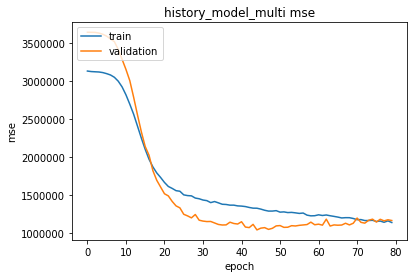

In [198]:
plt.plot(history_model_multi.history['main_output_loss'])
plt.plot(history_model_multi.history['val_main_output_loss'])
plt.title('history_model_multi mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [203]:
min(history_model_multi.history['val_main_output_loss'])

1038325.9032792441

| Model                                          | Epochs | val MSE   | batch size   | seq length  | training time |activation function |kaggle      |
| ---------------------------------------------- | ------ |---------- |---------- |------------ |-------------- |------------------- |----------- |
| Multi input model (model trained on subsample) | 25     |2,856,676  |32  |300          |46.61 min      |relu                |177,305,205 |
| Multi input model (model trained on all data)  | 25     |2,095,545  |32  |300          |276 min        |relu                | 86,263,429  |
| Multi input model (model trained on subsample, +1 Dense) | 21 |3,102,589 |256 |300 |17.08 min      |relu              |- |
| Multi input model (model trained on subsample) | 25     |3,102,589  |256  |300          |16.64 min      |relu                |- |
| Multi input model (model trained on subsample, + 2 Dense) | 25     |3,102,589  |256  |300          |20.3 min      |relu                |- |
| Multi input model (model trained on subsample, GRU(64)) | 25     |2,996,955  |256  |300          |27.25 min      |relu                |- |
| Multi input model (model trained on subsample, GRU(128)) | 25     |3,000,516  |256  |300          |20.3 min      |relu                |- |
| Multi input model (model trained on subsample, GRU(64) + 1 Dense) | 25     |2,963,726  |256  |300          |24.43 min      |relu                |- |
| Multi input model (model trained on all, GRU(64) + 1 Dense) | 80     |1,038,325  |256  |300          |356.13min      |relu                |72,961,508 |
| Multi input model (model trained on all, GRU(64) + 1 Dense) | 80     |1,038,325  |32  |300          |600min      |relu                |72,961,508 |
| Multi input model (model trained subsample, GRU(64) + 1 Dense, loss_weights={'main_output': 1., 'aux_output': 0.2}) | 25     |2,744,865  |256  |300          |40min      |relu                |- |
| Multi input model (model trained subsample, GRU(64) + 1 Dense, loss_weights={'main_output': 1., 'aux_output': 0.1}) | 25     |2,787,136  |256  |300          |40min      |relu                |- |
| Multi input model (model trained subsample, GRU(64) + 1 Dense, loss_weights={'main_output': 1., 'aux_output': 0.6}) | 25     |2,859,623  |256  |300          |40min      |relu                |- |
| Multi input model (model trained subsample, GRU(64) + 1 Dense, loss_weights={'main_output': 1., 'aux_output': 0.4}) | 25     |3,102,589  |256  |300          |40min      |relu                |- |
| Multi input model (model trained on all, GRU(64) + 1 Dense, loss_weights={'main_output': 1., 'aux_output': 0.2}) | 80     |1,217,934  |256  |300          |360min      |relu                |? |

---

## Predict on unknown data 

In [199]:
# Make prediction
pred_2 = model_multi.predict([padded_pred, pred_meta_data], verbose = 1)

# Combine to data frame
values = pd.Series(np.array([item[0] for item in pred_2[0]]))
pred_2_export = pd.concat([test['index'], values], axis = 1)
pred_2_export.columns = ['index', 'Claps']
pred_2_export['Claps'] = abs(pred_2_export['Claps'])

# Export as csv
pred_2_export.to_csv('pred_4_export.csv', index = False)

514/514 [==============================] - 22s 42ms/step


---

### New try larger batch size

In [261]:
epochs = 80

In [262]:
# Input for NLP branch of model
text_input = Input(shape=(major_sen,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(input_dim = num_words, output_dim = 512, embeddings_initializer=Constant(embedding_matrix),input_length=major_sen,trainable=False)(text_input)

# GRU layer
text_out = GRU(64)(x)

# Extra output from text branch
auxiliary_output = Dense(1, activation='relu', name='aux_output')(text_out)

# Extra input from non textual data (meta data)
auxiliary_input = Input(shape=(12,), name='aux_input')


# Concatenate branches
x = keras.layers.concatenate([text_out, auxiliary_input])

# One layer with relu function
x = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(x) 
#x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

# Main layer with relu activation function
main_output = Dense(1, activation='relu', name='main_output')(x)

model_multi_2 = Model(inputs=[text_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Compile model
model_multi_2.compile(optimizer='adam',
              loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'}
              ,loss_weights={'main_output': 1., 'aux_output': 0.2}
             )

# Define early stopping with callbacks
es = EarlyStopping(monitor='val_main_output_loss', mode='min', min_delta=1, patience=60,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_model_2.h5', monitor='val_main_output_loss', mode='min', verbose=1)

In [263]:
# Train model
start = time.time()
history_model_multi_2 = model_multi_2.fit({'text_input': X_train_nn1, 'aux_input': X_train_meta},
          {'main_output': y_train_nn1, 'aux_output': y_train_meta},
          epochs=epochs, batch_size=256, validation_data = ([X_test_nn1, X_test_meta], [y_test_nn1, y_test_meta]), verbose = 1, callbacks = [es, mc])
end = time.time()
print('Time for training multi input model on all of data:', round((end-start)/60,2))

Train on 54213 samples, validate on 18072 samples
Epoch 1/80
54213/54213 [==============================] - 388s 7ms/step - loss: 3769651.4873 - main_output_loss: 3133530.9178 - aux_output_loss: 3180603.0380 - val_loss: 4387990.7260 - val_main_output_loss: 3645056.9817 - val_aux_output_loss: 3714669.1254

Epoch 00001: saving model to best_model_2.h5
Epoch 2/80
54213/54213 [==============================] - 249s 5ms/step - loss: 3760573.9225 - main_output_loss: 3125097.8394 - aux_output_loss: 3177380.1495 - val_loss: 4382494.4931 - val_main_output_loss: 3639908.0984 - val_aux_output_loss: 3712932.0837

Epoch 00002: saving model to best_model_2.h5
Epoch 3/80
54213/54213 [==============================] - 245s 5ms/step - loss: 3754250.7032 - main_output_loss: 3119021.1841 - aux_output_loss: 3176147.6913 - val_loss: 4373536.0251 - val_main_output_loss: 3631145.3011 - val_aux_output_loss: 3711953.3203

Epoch 00003: saving model to best_model_2.h5
Epoch 4/80
54213/54213 [====================

In [264]:
#model_multi.save_weights("model_multi.h5")
#print("Saved model_multi to disk")

#model_multi_2.load_weights("best_model_2.h5")
#print("Loaded model from disk")
#history_model_multi.history

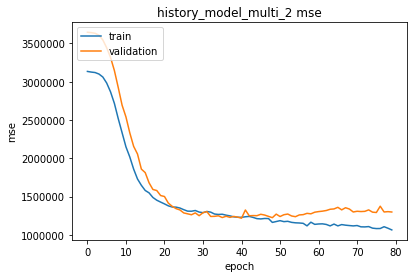

In [265]:
plt.plot(history_model_multi_2.history['main_output_loss'])
plt.plot(history_model_multi_2.history['val_main_output_loss'])
plt.title('history_model_multi_2 mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [266]:
min(history_model_multi_2.history['val_main_output_loss'])

1217934.8058564353

---

## Predict on unknown data 

In [268]:
# Make prediction
pred_6 = model_multi_2.predict([padded_pred, pred_meta_data], verbose = 1)

# Combine to data frame
values = pd.Series(np.array([item[0] for item in pred_6[0]]))
pred_6_export = pd.concat([test['index'], values], axis = 1)
pred_6_export.columns = ['index', 'Claps']
pred_6_export['Claps'] = abs(pred_6_export['Claps'])

# Export as csv
pred_6_export.to_csv('pred_6_export.csv', index = False)

514/514 [==============================] - 2s 4ms/step


### Model multi 5

In [272]:
# Input for NLP branch of model
text_input = Input(shape=(major_sen,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(input_dim = num_words, output_dim = 512, embeddings_initializer=Constant(embedding_matrix),input_length=major_sen,trainable=False)(text_input)

# GRU layer
text_out = GRU(64)(x)

# Extra output from text branch
auxiliary_output = Dense(1, activation='relu', name='aux_output')(text_out)

# Extra input from non textual data (meta data)
auxiliary_input = Input(shape=(12,), name='aux_input')


# Concatenate branches
x = keras.layers.concatenate([text_out, auxiliary_input])

# One layer with relu function
x = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(x) 
#x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

# Main layer with relu activation function
main_output = Dense(1, activation='relu', name='main_output')(x)

model_multi_5 = Model(inputs=[text_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Compile model
model_multi_5.compile(optimizer='adam',
              loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'}
              #,loss_weights={'main_output': 1., 'aux_output': 0.2}
             )

# Define early stopping with callbacks
es = EarlyStopping(monitor='val_main_output_loss', mode='min', min_delta=1, patience=60,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_model_2.h5', monitor='val_main_output_loss', mode='min', verbose=1)

In [273]:
## Model 5
model_multi_5.load_weights("best_model_5.h5")
print("Loaded model from disk")

Loaded model from disk


In [281]:
#([X_test_nn1, X_test_meta], [y_test_nn1, y_test_meta])
mse = model_multi_2.predict([X_test_nn1, X_test_meta], verbose = 1)

2500/2500 [==============================] - 9s 3ms/step


In [279]:
# Combine to data frame
mse = pd.Series(np.array([item[0] for item in mse[0]]))


In [283]:
# Make prediction
pred_5 = model_multi_2.predict([padded_pred, pred_meta_data], verbose = 1)

# Combine to data frame
values = pd.Series(np.array([item[0] for item in pred_5[0]]))
pred_5_export = pd.concat([test['index'], values], axis = 1)
pred_5_export.columns = ['index', 'Claps']
pred_5_export['Claps'] = abs(pred_5_export['Claps'])

# Export as csv
pred_5_export.to_csv('pred_5_export.csv', index = False)

514/514 [==============================] - 2s 4ms/step


# Fine tune multi input model

In [ ]:
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
epochs = 100

In [ ]:
# Input for NLP branch of model
text_input = Input(shape=(major_sen,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(input_dim = num_words, output_dim = 512, embeddings_initializer=Constant(embedding_matrix),input_length=major_sen,trainable=False)(text_input)

# GRU layer
text_out = GRU(32)(x)

# Bidirectional GRU layer
#text_out = Bidirectional(GRU(16), merge_mode="concat")

# Extra output from text branch
auxiliary_output = Dense(1, activation='relu', name='aux_output')(text_out)

# Extra input from non textual data (meta data)
auxiliary_input = Input(shape=(12,), name='aux_input')
# insert dense layer here 
# Concatenate branches
x = keras.layers.concatenate([text_out, auxiliary_input])

# One layer with relu function
x = Dense(16, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

# Main layer with relu activation function
main_output = Dense(1, activation='relu', name='main_output')(x)

model_multi = Model(inputs=[text_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Compile model
model_multi.compile(optimizer = sgd,
              loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'}
              #,loss_weights={'main_output': 1., 'aux_output': 0.2}
             )

# Define early stopping with callbacks
es = EarlyStopping(monitor='val_main_output_loss', mode='min', min_delta=1, patience=60,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_model_4.h5', monitor='val_main_output_loss', mode='min', verbose=1)

In [ ]:
# Train model
start = time.time()
history_model_multi_4 = model_multi.fit({'text_input': X_train_nn1, 'aux_input': X_train_meta},
          {'main_output': y_train_nn1, 'aux_output': y_train_meta},
          epochs=epochs, batch_size = 128, validation_data = ([X_test_nn1, X_test_meta], [y_test_nn1, y_test_meta]), verbose = 1, callbacks = [es, mc])
end = time.time()
print('Time for training multi input model on part of data:', round((end-start)/60,2))

In [ ]:
model_multi.save_weights("model_multi_4.h5")
print("Saved model_multi_4 to disk")

#model_multi.load_weights("model_multi.h5")
#print("Loaded model from disk")
#history_model_multi.history

In [ ]:
plt.plot(history_model_multi_4.history['main_output_loss'])
plt.plot(history_model_multi_4.history['val_main_output_loss'])
plt.title('history_model_multi_4 mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

---

## Predict on unknown data 

In [ ]:
# Make prediction
pred_4 = history_model_multi_4.predict([padded_pred, pred_meta_data], verbose = 1)

# Combine to data frame
values = pd.Series(np.array([item[0] for item in pred_4[0]]))
pred_4_export = pd.concat([test['index'], values], axis = 1)
pred_4_export.columns = ['index', 'Claps']
pred_4_export['Claps'] = abs(pred_4_export['Claps'])

# Export as csv
pred_4_export.to_csv('pred_4_export.csv', index = False)